# Tarea 3

Valor de A: 4.4620e+02
Número total de estrellas en bins: 10000.00


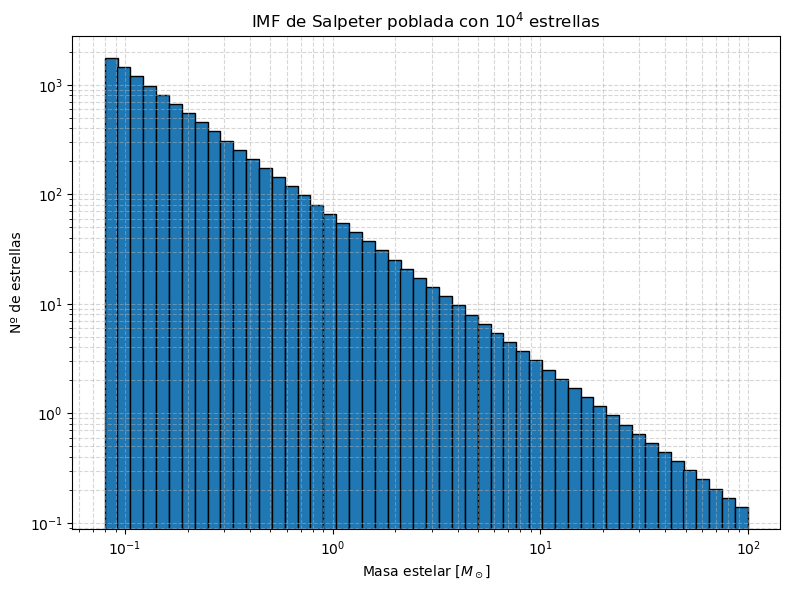

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parámetros de la IMF de Salpeter
x = 1.35
m_min = 0.08  # masas solares
m_max = 100.0
N_total = 1e4  # número total de estrellas

# Definir la IMF
def imf_salpeter(m, A):
    return A * m**(-(1 + x))

# Integral para normalizar la IMF
integral_imf, _ = quad(lambda m: m**(-(1 + x)), m_min, m_max)

# Factor de normalización A
A = N_total / integral_imf
print(f"Valor de A: {A:.4e}")


# Crear 51 bordes para 50 bins en espacio logarítmico
log_edges = np.linspace(np.log10(m_min), np.log10(m_max), 51)
mass_edges = 10**log_edges

# Valores medios (logarítmicos) para el eje x del histograma
mass_centers = np.sqrt(mass_edges[:-1] * mass_edges[1:])  # media geométrica


# Calcular número de estrellas por bin usando integración
N_bins = []
for i in range(50):
    mi, mf = mass_edges[i], mass_edges[i + 1]
    Ni, _ = quad(imf_salpeter, mi, mf, args=(A,))
    N_bins.append(Ni)

N_bins = np.array(N_bins)

# Verificación
print(f"Número total de estrellas en bins: {np.sum(N_bins):.2f}")

plt.figure(figsize=(8, 6))
plt.bar(mass_centers, N_bins, width=np.diff(mass_edges), align='center', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Masa estelar [$M_\\odot$]")
plt.ylabel("Nº de estrellas")
plt.title("IMF de Salpeter poblada con $10^4$ estrellas")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("Histograma Salpeter")
plt.tight_layout()
plt.show()



In [2]:
import tarfile
import os

# Ruta al archivo
archivo_tar = "templates.tar.gz"
carpeta_destino = "spectra"

# Extraer todos los archivos
with tarfile.open(archivo_tar, "r") as tar:

    tar.extractall(path=carpeta_destino)

# Verificar archivos extraídos
archivos = sorted(os.listdir(carpeta_destino))
print("Archivos extraídos:", archivos)



Archivos extraídos: ['spectrum_A5V.fits', 'spectrum_B57V.fits', 'spectrum_F5V.fits', 'spectrum_G5V.fits', 'spectrum_K5V.fits', 'spectrum_M5V.fits', 'spectrum_O5V.fits']


In [10]:
from astropy.io import fits
import numpy as np

# Ruta a los archivos extraídos
ruta = "spectra"

# Crear diccionario con los espectros
espectros = {}

for archivo in archivos:
    tipo = archivo.split("_")[1].replace(".fits", "")  # ej: A5V
    with fits.open(os.path.join(ruta, archivo)) as hdul:
        data = hdul[1].data  # usualmente está en la extensión 1
        wave = data['wave_nm']  # eje x: longitud de onda [nm]
        flux = data['f_lambda']  # eje y: flujo normalizado
        espectros[tipo] = {
            "wave": wave,
            "flux": flux
        }


import pandas as pd

# Crear lista de resumen
resumen = []

for tipo, datos in espectros.items():
    wave = datos["wave"]
    flux = datos["flux"]
    resumen.append({
        "Tipo": tipo,
        "Puntos": len(wave),
        "λ min [nm]": np.min(wave),
        "λ max [nm]": np.max(wave),
        "∑ flujo": np.sum(flux)
    })

# Crear tabla
tabla = pd.DataFrame(resumen).sort_values(by="Tipo")
print(tabla)

print(espectros["A5V"])

   Tipo  Puntos  λ min [nm]  λ max [nm]  ∑ flujo
0   A5V    4771       115.0      2500.0      1.0
1  B57V    4771       115.0      2500.0      1.0
2   F5V    4771       115.0      2500.0      1.0
3   G5V    4771       115.0      2500.0      1.0
4   K5V    4771       115.0      2500.0      1.0
5   M5V    4771       115.0      2500.0      1.0
6   O5V    4771       115.0      2500.0      1.0
{'wave': array([ 115. ,  115.5,  116. , ..., 2499. , 2499.5, 2500. ], dtype='>f8'), 'flux': array([0.00000000e+00, 7.42768167e-06, 2.60585873e-05, ...,
       5.72648401e-06, 5.71913860e-06, 0.00000000e+00], dtype='>f8')}


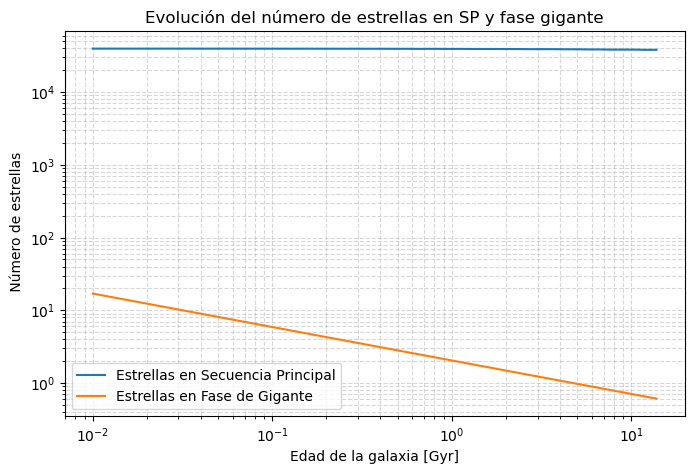

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
x = 1.35
alpha = 3.5
tau_sun = 10.0  # Gyr
m_min = 0.08
m_max = 100
tau_g = 0.01  # Gyr, duración fase gigante (ejemplo)

# Factor de normalización A (ya calculado, pon aquí tu valor)
A = 1769.66  # ejemplo, reemplaza por tu valor

# Bins de masa (logarítmicos), y número de estrellas en cada bin (N_bin)
# Ejemplo: bins de masa centrados en m_bins_centers, y N_bin calculados antes
# Aquí se ponen valores ejemplo, reemplaza con tus datos reales
m_bins_edges = np.logspace(np.log10(m_min), np.log10(m_max), 51)  # 50 bins
m_bins_centers = 10**((np.log10(m_bins_edges[:-1]) + np.log10(m_bins_edges[1:]))/2)

# Función IMF integrando en cada bin (ya hecha por ti), ejemplo de N_bin
def imf_integral(m1, m2, A, x):
    # Integral de phi(m) = A m^{-(1+x)} dm
    # integral = A/(x) * (m1^{-x} - m2^{-x})
    return A / x * (m1**(-x) - m2**(-x))

N_bin = np.array([imf_integral(m_bins_edges[i], m_bins_edges[i+1], A, x) for i in range(len(m_bins_edges)-1)])

# Función para masa de turno m_to(t)
def m_turnoff(t, tau_sun=10, alpha=3.5):
    # Evitar división por cero o t=0
    if t <= 0:
        return m_max
    exponent = 1 / (1 - alpha)
    return m_sun * (t / tau_sun) ** exponent

# Ahora para un tiempo t dado:
def N_SP(t, m_bins_edges, N_bin):
    m_to = m_turnoff(t, tau_sun, alpha)
    # Sumamos las estrellas con masa < m_to
    mask = m_bins_centers < m_to
    return N_bin[mask].sum()

def dmdt(t, tau_sun=10, alpha=3.5):
    # Derivada dm_to/dt = (1/(1-alpha)) * M_sun * (t/tau_sun)^{(alpha/(1-alpha))} * (1/tau_sun)
    if t <= 0:
        return 0
    exponent = alpha / (1 - alpha)
    return (1 / (1 - alpha)) * m_sun * (t / tau_sun) ** exponent * (1 / tau_sun)

def N_gigantes(t, A, x, tau_g, tau_sun=10, alpha=3.5):
    m_to = m_turnoff(t, tau_sun, alpha)
    # phi(m_to) = A m_to^{-(1+x)}
    phi_m_to = A * m_to ** (-(1 + x))
    dmdt_val = abs(dmdt(t, tau_sun, alpha))
    return phi_m_to * dmdt_val * tau_g

# Constantes
m_sun = 1  # masas solares en unidades M_sun

# Ejemplo de uso:
edades = np.logspace(-2, np.log10(13.8), 50)  # entre 0.01 y 13.8 Gyr
Nsp_vals = [N_SP(t, m_bins_edges, N_bin) for t in edades]
Ng_vals = [N_gigantes(t, A, x, tau_g, tau_sun, alpha) for t in edades]

# Graficar
plt.figure(figsize=(8,5))
plt.plot(edades, Nsp_vals, label="Estrellas en Secuencia Principal")
plt.plot(edades, Ng_vals, label="Estrellas en Fase de Gigante")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Edad de la galaxia [Gyr]")
plt.ylabel(" Número de estrellas")
plt.title("Evolución del número de estrellas en SP y fase gigante")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


In [ ]:
alpha = 3.5
L_sun = 1.0  # unidad solar

# Luminosidad para estrellas en secuencia principal
L_SP = L_sun * m_bins_centers ** alpha

# Luminosidad para estrellas gigantes (constante)
L_giant = 100 * L_sun


print(L_SP)

def tipo_espectral(masa):
    if masa > 16:
        return 'O'
    elif masa > 2.1:
        return 'B'
    elif masa > 1.4:
        return 'A'
    elif masa > 1.04:
        return 'F'
    elif masa > 0.8:
        return 'G'
    elif masa > 0.45:
        return 'K'
    else:
        return 'M'

# Asignar tipo espectral a cada bin
tipos_sp = [tipo_espectral(m) for m in m_bins_centers]

# Para estrellas gigantes, asumimos tipo espectral fijo, por ejemplo 'K'
tipo_gigantes = 'K'


[1.85868933e-04 3.06189650e-04 5.04398988e-04 8.30917504e-04
 1.36880508e-03 2.25488973e-03 3.71457396e-03 6.11917271e-03
 1.00803686e-02 1.66058119e-02 2.73554469e-02 4.50637693e-02
 7.42354278e-02 1.22291118e-01 2.01455263e-01 3.31865662e-01
 5.46696155e-01 9.00595392e-01 1.48358837e+00 2.44397704e+00
 4.02606538e+00 6.63230552e+00 1.09256737e+01 1.79983182e+01
 2.96493807e+01 4.88426622e+01 8.04605559e+01 1.32546032e+02
 2.18348609e+02 3.59694777e+02 5.92540217e+02 9.76116228e+02
 1.60799700e+03 2.64892056e+03 4.36367740e+03 7.18846788e+03
 1.18418631e+04 1.95075954e+04 3.21356760e+04 5.29384401e+04
 8.72077017e+04 1.43660887e+05 2.36658574e+05 3.89857545e+05
 6.42228605e+05 1.05796998e+06 1.74283811e+06 2.87104995e+06
 4.72960039e+06 7.79126811e+06]


['M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'K',
 'K',
 'K',
 'K',
 'G',
 'G',
 'F',
 'F',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

[(129.00628942, 30.26641313, 16.428698, 14.782145, 14.069825, 13.736944, 0.02560202)
 (129.00782693, 15.9713169 , 19.258604, 17.207989, 16.117191, 15.664119, 0.12030722)
 (129.18625991, 47.27297586, 18.898148, 16.938633, 16.037817, 15.628127, 0.05173724)
 ...
 (219.60714577, 18.57253965, 18.936853, 16.947308, 15.97141 , 15.538984, 0.09467263)
 (219.67209294, 28.99725575, 22.131588, 19.162912, 17.664097, 17.142279, 0.24738036)
 (219.79230448,  9.32422361, 20.8916  , 18.845312, 17.717752, 17.286415, 0.1710101 )]


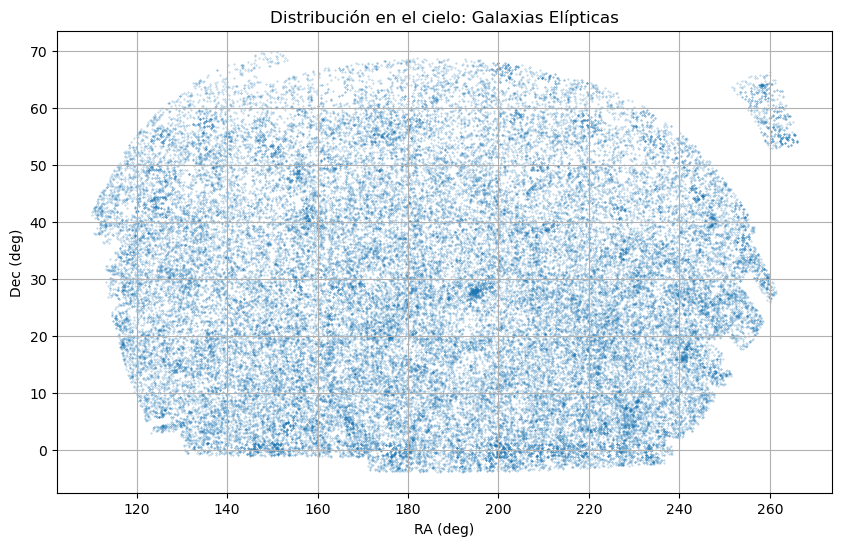

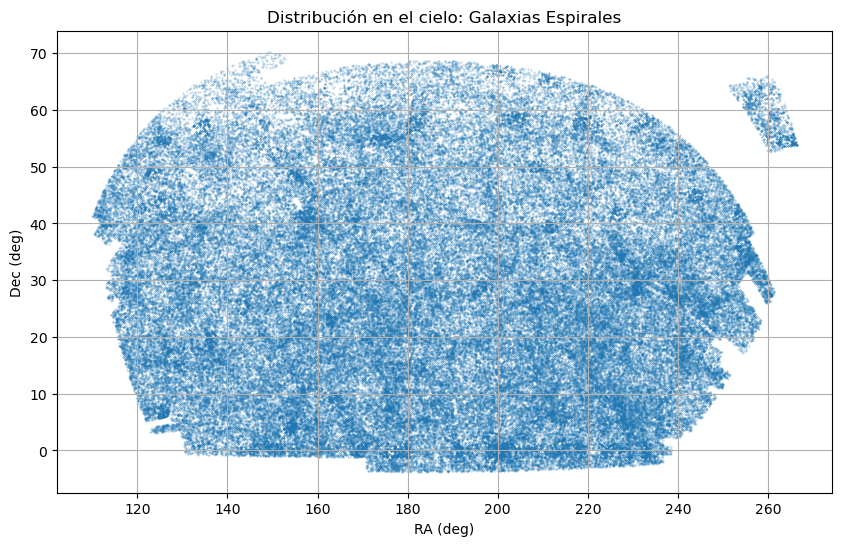

KeyError: "Key 'z' does not exist."

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology as cosmo

# Configuración inicial
cosmo = cosmo.Planck15  # Usamos cosmología Planck 2015
mlim_r = 17.77  # Límite de magnitud en banda r
omega_deg = 9320  # Área en grados cuadrados
omega_sr = omega_deg * (np.pi/180)**2  # Convertir a estereorradianes

# Función para calcular distancia máxima
def dmax(M, mlim):
    return 10 * 10**((mlim - M)/5)  # en parsecs

# Función para calcular Vmax
def vmax(M, mlim, omega):
    d_max = dmax(M, mlim)
    return (4/3) * np.pi * d_max**3 * (omega/(4*np.pi))  # en pc^3

# Cargar datos de galaxias elípticas y espirales
def load_data(filename):
    with fits.open(filename) as hdul:
        data = hdul[1].data
    return data

ellipticals = load_data('ellipticals.fits')
spirals = load_data('spirals.fits')

print(ellipticals)
# Graficar distribución en el cielo
def plot_sky_distribution(data, title):
    ra = data['RA']
    dec = data['DEC']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(ra, dec, s=0.1, alpha=0.5)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.title(f'Distribución en el cielo: {title}')
    plt.grid(True)
    plt.show()

plot_sky_distribution(ellipticals, 'Galaxias Elípticas')
plot_sky_distribution(spirals, 'Galaxias Espirales')

# Análisis de profundidad
def analyze_depth(data, title):
    # Asumimos que los datos tienen magnitud aparente 'r' y redshift 'z'
    r_mag = data['r']
    z = data['z']
    
    plt.figure(figsize=(12, 5))
    
    # Histograma de magnitudes
    plt.subplot(121)
    plt.hist(r_mag, bins=50)
    plt.axvline(mlim_r, color='red', linestyle='--', label=f'Límite r={mlim_r}')
    plt.xlabel('Magnitud aparente r')
    plt.ylabel('Número de galaxias')
    plt.title(f'Distribución de magnitudes: {title}')
    plt.legend()
    
    # Redshift vs magnitud
    plt.subplot(122)
    plt.scatter(z, r_mag, s=0.1, alpha=0.3)
    plt.axhline(mlim_r, color='red', linestyle='--')
    plt.xlabel('Redshift z')
    plt.ylabel('Magnitud aparente r')
    plt.title(f'Redshift vs magnitud: {title}')
    
    plt.tight_layout()
    plt.show()

analyze_depth(ellipticals, 'Galaxias Elípticas')
analyze_depth(spirals, 'Galaxias Espirales')

# Análisis de completitud
def check_completeness(data, title):
    r_mag = data['r']
    completeness = np.sum(r_mag < mlim_r) / len(r_mag)
    print(f"Completitud para {title}: {completeness*100:.2f}% (r < {mlim_r})")

check_completeness(ellipticals, 'Galaxias Elípticas')
check_completeness(spirals, 'Galaxias Espirales')


Columnas disponibles en Galaxias Elípticas:
['ra', 'dec', 'u', 'g', 'r', 'i', 'redshift']


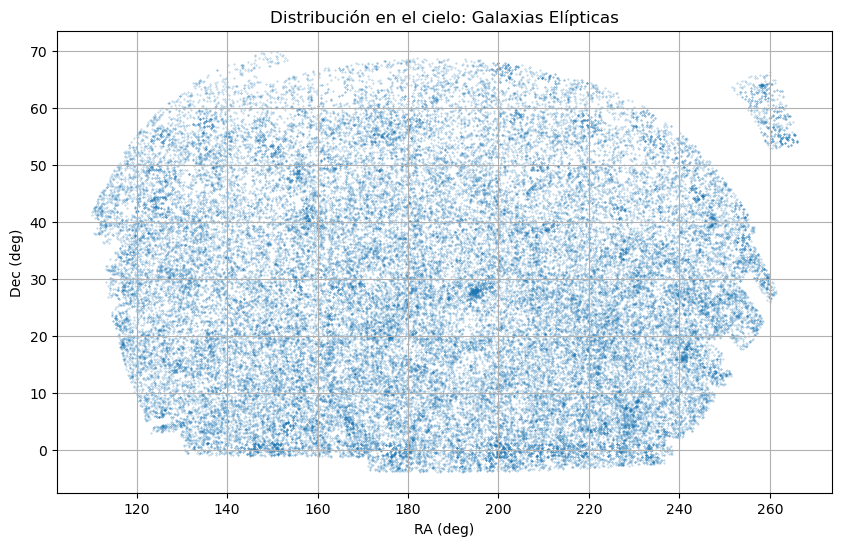

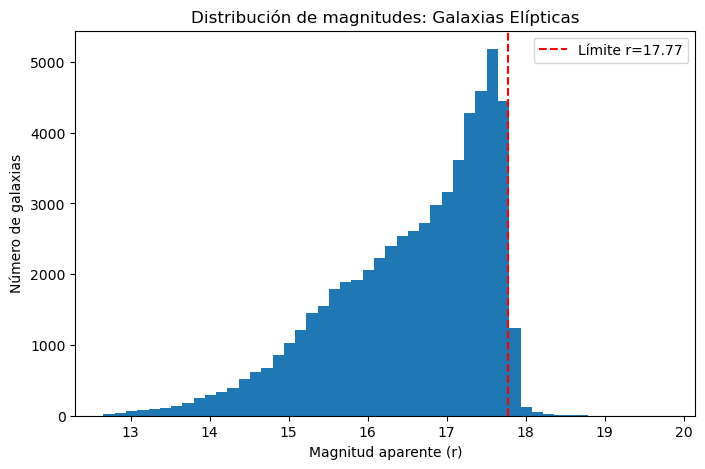

Fracción de galaxias con r ≤ 17.77: 96.80%


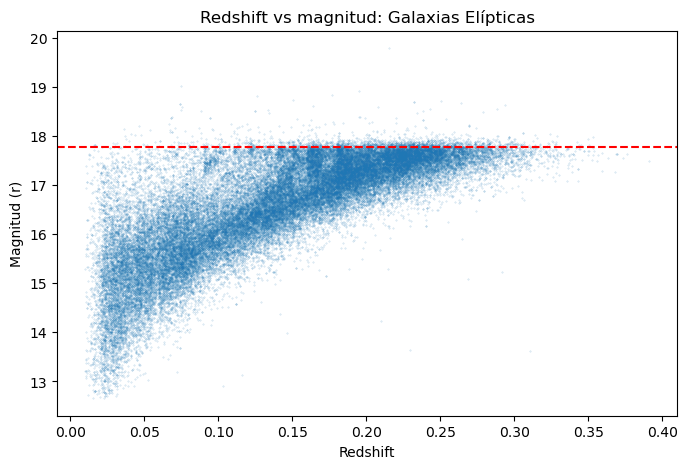


Columnas disponibles en Galaxias Espirales:
['ra', 'dec', 'u', 'g', 'r', 'i', 'redshift']


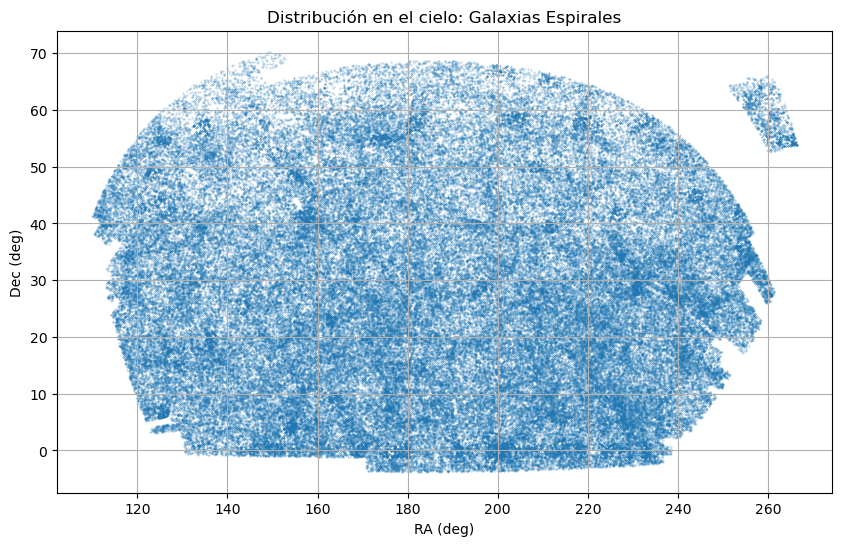

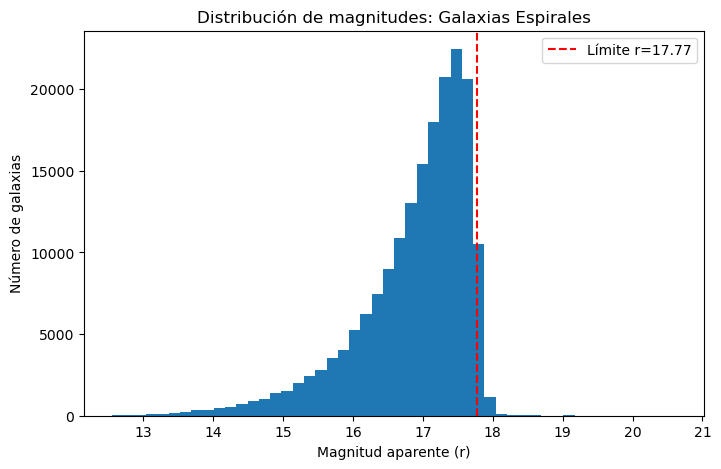

Fracción de galaxias con r ≤ 17.77: 96.23%


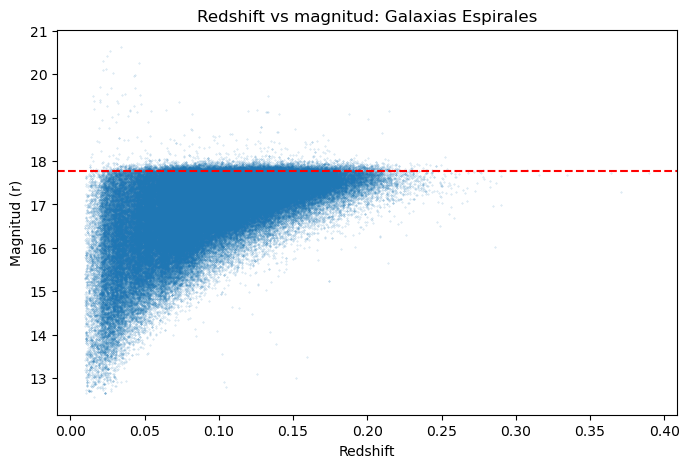

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

def load_and_analyze(filename, galaxy_type):
    # Cargar datos
    with fits.open(filename) as hdul:
        data = hdul[1].data
    
    # Mostrar información de las columnas disponibles
    print(f"\nColumnas disponibles en {galaxy_type}:")
    print(data.columns.names)
    
    # Graficar distribución en el cielo
    plt.figure(figsize=(10, 6))
    plt.scatter(data['RA'], data['DEC'], s=0.1, alpha=0.5)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.title(f'Distribución en el cielo: {galaxy_type}')
    plt.grid(True)
    plt.show()
    
    # Verificar si tenemos magnitudes (buscamos nombres alternativos)
    mag_key = None
    possible_mag_keys = ['r', 'modelMag_r', 'cModelMag_r', 'r_mag', 'mag_r']
    for key in possible_mag_keys:
        if key in data.columns.names:
            mag_key = key
            break
    
    if mag_key:
        # Histograma de magnitudes
        plt.figure(figsize=(8, 5))
        plt.hist(data[mag_key], bins=50)
        plt.axvline(17.77, color='red', linestyle='--', label='Límite r=17.77')
        plt.xlabel(f'Magnitud aparente ({mag_key})')
        plt.ylabel('Número de galaxias')
        plt.title(f'Distribución de magnitudes: {galaxy_type}')
        plt.legend()
        plt.show()
        
        # Completitud
        completitud = np.sum(data[mag_key] <= 17.77) / len(data[mag_key])
        print(f"Fracción de galaxias con {mag_key} ≤ 17.77: {completitud:.2%}")
    else:
        print("No se encontró columna de magnitud en los datos")
    
    # Verificar si tenemos redshift
    z_key = None
    possible_z_keys = ['z', 'redshift', 'Z', 'Z_SPEC']
    for key in possible_z_keys:
        if key in data.columns.names:
            z_key = key
            break
    
    if z_key and mag_key:
        # Redshift vs magnitud
        plt.figure(figsize=(8, 5))
        plt.scatter(data[z_key], data[mag_key], s=0.1, alpha=0.3)
        plt.axhline(17.77, color='red', linestyle='--')
        plt.xlabel('Redshift')
        plt.ylabel(f'Magnitud ({mag_key})')
        plt.title(f'Redshift vs magnitud: {galaxy_type}')
        plt.show()
    elif not z_key:
        print("No se encontró columna de redshift en los datos")

# Analizar ambos catálogos
load_and_analyze('ellipticals.fits', 'Galaxias Elípticas')
load_and_analyze('spirals.fits', 'Galaxias Espirales')


Procesando: Elípticas

Procesando: Espirales


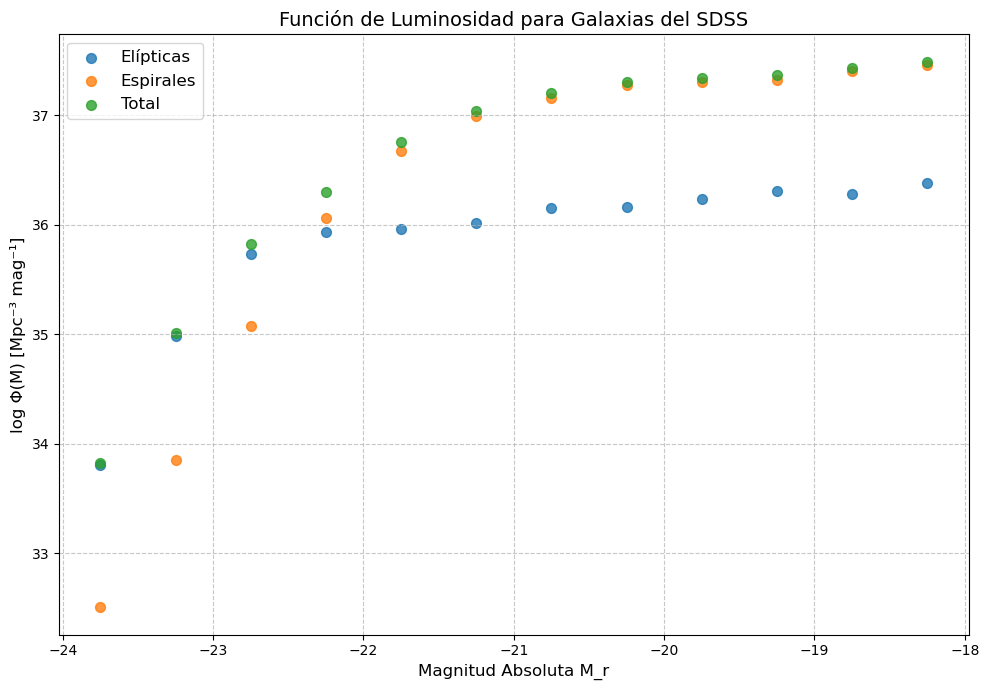

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import binned_statistic

# Configuración cosmológica
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Parámetros del SDSS
mlim_r = 17.77  # Magnitud límite en banda r
omega_deg2 = 9320  # Área en grados cuadrados
omega_sr = omega_deg2 * (np.pi/180)**2  # Área en estereorradianes

def load_data(filename):
    """Carga los datos y verifica las columnas necesarias"""
    with fits.open(filename) as hdul:
        data = hdul[1].data
    
    # Buscar nombres alternativos para las columnas necesarias
    mag_keys = ['r', 'modelMag_r', 'cModelMag_r', 'r_mag', 'mag_r']
    z_keys = ['z', 'redshift', 'Z', 'Z_SPEC']
    
    mag_col = next((key for key in mag_keys if key in data.columns.names), None)
    z_col = next((key for key in z_keys if key in data.columns.names), None)
    
    if mag_col is None or z_col is None:
        raise ValueError("No se encontraron las columnas necesarias (magnitud y redshift)")
    
    return data[mag_col], data[z_col]

def calculate_abs_mag(app_mag, z):
    """Calcula la magnitud absoluta usando distancia de luminosidad"""
    dl = cosmo.luminosity_distance(z).to(u.pc).value  # Distancia luminosidad en pc
    abs_mag = app_mag - 5 * np.log10(dl) + 5  # Fórmula de distancia módulo
    return abs_mag

def calculate_vmax(abs_mag):
    """Calcula el volumen máximo Vmax para una magnitud absoluta dada"""
    dmax = 10 * 10**((mlim_r - abs_mag)/5)  # Distancia máxima en pc
    vmax = (4/3) * np.pi * dmax**3 * (omega_sr/(4*np.pi))  # Volumen en pc^3
    return vmax / (3.086e19)**3  # Convertir a Mpc^3

def compute_luminosity_function(magnitudes, redshifts, mag_range=(-24, -18), bin_width=0.5):
    """Calcula la función de luminosidad Φ(M)"""
    # Calcular magnitudes absolutas
    abs_mags = calculate_abs_mag(magnitudes, redshifts)
    
    # Filtrar galaxias en el rango de interés
    mask = (abs_mags >= mag_range[0]) & (abs_mags <= mag_range[1])
    abs_mags = abs_mags[mask]
    
    # Crear bins para las magnitudes absolutas
    bins = np.arange(mag_range[0], mag_range[1] + bin_width, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calcular histograma de magnitudes absolutas
    hist, bin_edges = np.histogram(abs_mags, bins=bins)
    
    # Calcular Vmax para el centro de cada bin
    vmax_bins = np.array([calculate_vmax(bc) for bc in bin_centers])
    
    # Calcular Φ(M) para cada bin
    phi = hist / (vmax_bins * bin_width)  # [Mpc⁻³ mag⁻¹]
    
    return bin_centers, phi, hist

# Procesar ambos catálogos
results = {}
for filename, gal_type in [('ellipticals.fits', 'Elípticas'), ('spirals.fits', 'Espirales')]:
    try:
        print(f"\nProcesando: {gal_type}")
        mag, z = load_data(filename)
        
        # Filtrar datos válidos (r < mlim_r y z > 0)
        valid = (mag <= mlim_r) & (z > 0)
        mag = mag[valid]
        z = z[valid]
        
        # Calcular función de luminosidad
        bin_centers, phi, hist = compute_luminosity_function(mag, z)
        results[gal_type] = (bin_centers, phi, hist)
        
    except Exception as e:
        print(f"Error procesando {filename}: {str(e)}")

# Calcular muestra total combinando ambas poblaciones
if 'Elípticas' in results and 'Espirales' in results:
    total_phi = results['Elípticas'][1] + results['Espirales'][1]
    results['Total'] = (results['Elípticas'][0], total_phi, 
                       results['Elípticas'][2] + results['Espirales'][2])

# Graficar resultados
plt.figure(figsize=(10, 7))
for gal_type, (bin_centers, phi, hist) in results.items():
    plt.scatter(bin_centers, np.log10(phi), label=gal_type, s=50, alpha=0.8)

plt.xlabel('Magnitud Absoluta M_r', fontsize=12)
plt.ylabel('log Φ(M) [Mpc⁻³ mag⁻¹]', fontsize=12)
plt.title('Función de Luminosidad para Galaxias del SDSS', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [32]:
# Asumiendo que tienes los datos en estas variables:
# bin_centers_elipticas, phi_elipticas
# bin_centers_espirales, phi_espirales
# bin_centers_total, phi_total

plt.figure(figsize=(10, 7))

# Graficar con estilos distintos para cada tipo
plt.scatter(bin_centers_elipticas, np.log10(phi_elipticas), 
            label='Elípticas', s=100, marker='s', color='red')
plt.scatter(bin_centers_espirales, np.log10(phi_espirales), 
            label='Espirales', s=100, marker='o', color='blue')
plt.scatter(bin_centers_total, np.log10(phi_total), 
            label='Total', s=100, marker='^', color='green')

# Configuración de ejes
plt.xlabel('Magnitud Absoluta M_r', fontsize=14)
plt.ylabel('log Φ(M) [Mpc⁻³ mag⁻¹]', fontsize=14)
plt.title('Función de Luminosidad para Galaxias del SDSS', fontsize=16)

# Rango y ticks más precisos
plt.xlim(-21.5, -17.5)
plt.ylim(-7, -3)  # Ajusta según tus datos reales
plt.xticks(np.arange(-21.5, -17.5, 0.5))
plt.yticks(np.arange(-7, -2.5, 0.5))

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('funcion_luminosidad_mejorada.png', dpi=300)
plt.show()

NameError: name 'bin_centers_elipticas' is not defined

<Figure size 1000x700 with 0 Axes>